# FREDから経済データを取得+ベイズ時系列解析

In [1]:
using Distributed
addprocs(3)

3-element Array{Int64,1}:
 2
 3
 4

In [2]:
@everywhere using Mamba
using DataFrames
using Dates
using Distributions
using DotEnv
DotEnv.config();
using HTTP
import ForneyLab.dot2svg
using JSON
using Plots
using Printf
using StatsBase

[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
[ Info: Loading DataFrames support into Gadfly.jl
┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /Users/apple/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228


# 経済データの取得

In [3]:
timeseries_url = @sprintf(
    "https://api.stlouisfed.org/fred/series/observations?series_id=%s&api_key=%s&file_type=json",
    "LNU02000000",
    ENV["FRED_API_KEY"])
r = HTTP.get(timeseries_url)
obs_vec = JSON.parse(IOBuffer(r.body))["observations"]
obs_df = DataFrame(permutedims(hcat(collect.(values.(obs_vec))...), (2, 1)), Symbol.(collect(keys(obs_vec[1]))))

for x in [:realtime_start, :realtime_end, :date]
    obs_df[x] = Date.(obs_df[x] ,"y-m-d")
end

# milion of persons
obs_df[:value] = parse.(Float64, obs_df[:value]) ./ 10^3

855-element Array{Float64,1}:
  56.339
  56.44 
  56.601
  57.471
  57.763
  59.724
  59.955
  59.677
  59.337
  59.29 
  58.991
  58.554
  56.486
   ⋮    
 155.348
 156.009
 156.465
 157.004
 155.539
 156.191
 156.952
 157.015
 156.481
 154.964
 156.167
 156.441

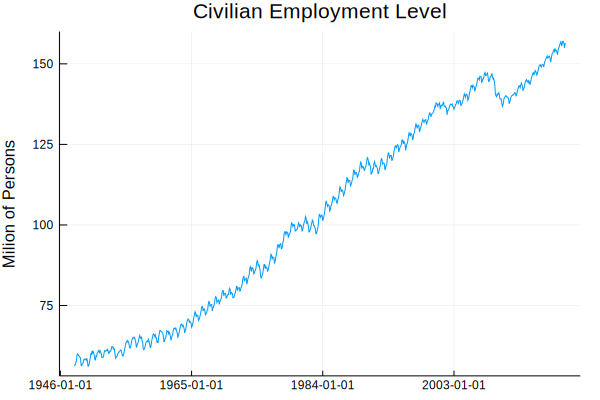

In [4]:
Plots.plot(obs_df[:date], obs_df[:value],
    title = "Civilian Employment Level",
    ylabel = "Milion of Persons", 
    label = "")

2010年以降のデータを対象とする

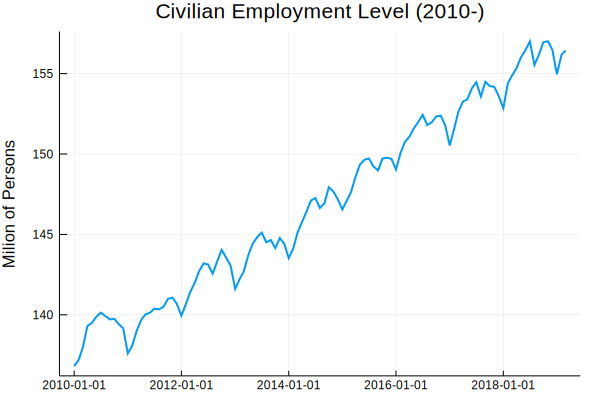

In [5]:
data_df = obs_df[obs_df[:date] .>= Date(2010,1,1), [:date, :value]]
Plots.plot(data_df[:date], data_df[:value],
    linewidth = 2,
    title = "Civilian Employment Level (2010-)",
    ylabel = "Milion of Persons", 
    label = "")

# Bayesian Linear Regression Model

In [6]:
# Reference: Mamba model in the tutorial
# https://mambajl.readthedocs.io/en/release-0.12/tutorial.html
# © Copyright 2014, Brian J Smith

linear_model = Model(

    obs = Stochastic(1,
        (mu, s2) ->  MvNormal(mu, sqrt(s2)),
        false,
    ),

    mu = Logical(1,
        (xmat, beta) -> xmat * beta,
        false
    ),

    beta = Stochastic(1,
        () -> MvNormal(2, sqrt(1000))
    ),

    s2 = Stochastic(
        () -> InverseGamma(0.001, 0.001)
    )

)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
mu:
An unmonitored node of type "0-element ArrayLogical{1}"
Float64[]
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2:
A monitored node of type "ScalarStochastic"
NaN


In [7]:
df_size = size(data_df, 1)
linear_data = Dict(
    :xmat => [ones(df_size) 0:df_size-1],
    :obs => data_df[:value],
)

Dict{Symbol,Array{Float64,N} where N} with 2 entries:
  :xmat => [1.0 0.0; 1.0 1.0; … ; 1.0 109.0; 1.0 110.0]
  :obs  => [136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.…

In [8]:
linear_inits = [
    Dict(
        :obs => data_df[:value],
        :beta => rand(Normal(0, sqrt(1000)), 2),
        :s2 => rand(Gamma(1, 1)),
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>[33.3164, 22.4924],:obs=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  156.465, 157.004, 155.539, 156.191, 156.952, 157.015, 156.481, 154.964, 156.167, 156.441],:s2=>3.41398)  
 Dict(:beta=>[65.8244, -10.3092],:obs=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  156.465, 157.004, 155.539, 156.191, 156.952, 157.015, 156.481, 154.964, 156.167, 156.441],:s2=>0.354986)
 Dict(:beta=>[9.97194, 13.8254],:obs=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  156.465, 157.004, 155.539, 156.191, 156.952, 157.015, 156.481, 154.964, 156.167, 156.441],:s2=>1.57216)  

In [9]:
linear_scheme = [NUTS(:beta), Slice(:s2, 3.0)]
setsamplers!(linear_model, linear_scheme)
linear_sim = mcmc(linear_model, linear_data, linear_inits, 8000, burnin = 3000, thin=5, chains=3)

MCMC Simulation of 8000 Iterations x 3 Chains...

      From worker 3:	Chain 3:   0% [0:58:04 of 0:58:08 remaining]
      From worker 4:	Chain 2:   0% [0:56:14 of 0:56:18 remaining]
      From worker 2:	Chain 1:   0% [0:57:30 of 0:57:35 remaining]
      From worker 3:	Chain 3:  10% [0:00:56 of 0:01:03 remaining]
      From worker 2:	Chain 1:  10% [0:00:60 of 0:01:07 remaining]
      From worker 4:	Chain 2:  10% [0:01:00 of 0:01:07 remaining]
      From worker 3:	Chain 3:  20% [0:00:35 of 0:00:44 remaining]
      From worker 4:	Chain 2:  20% [0:00:36 of 0:00:46 remaining]
      From worker 2:	Chain 1:  20% [0:00:37 of 0:00:47 remaining]
      From worker 3:	Chain 3:  30% [0:00:27 of 0:00:38 remaining]
      From worker 4:	Chain 2:  30% [0:00:27 of 0:00:38 remaining]
      From worker 2:	Chain 1:  30% [0:00:27 of 0:00:39 remaining]
      From worker 3:	Chain 3:  40% [0:00:22 of 0:00:36 remaining]
      From worker 4:	Chain 2:  40% [0:00:22 of 0:00:36 remaining]
      From worker 2:	Chain

Object of type "ModelChains"

Iterations = 3005:8000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1000

[0.71433 137.188 0.180769; 0.971146 137.093 0.181709; … ; 0.781069 137.183 0.180513; 0.772373 137.143 0.181331]

[0.63091 137.051 0.180992; 0.855195 137.036 0.181046; … ; 1.04967 136.89 0.184364; 0.814759 136.956 0.18038]

[0.796732 137.032 0.181516; 0.90796 136.981 0.181245; … ; 0.614827 137.157 0.179098; 0.720324 137.124 0.180707]

In [10]:
describe(linear_sim)

Iterations = 3005:8000
Thinning interval = 5
Chains = 1,2,3
Samples per chain = 1000

Empirical Posterior Estimates:
            Mean         SD         Naive SE        MCSE      ESS
     s2   0.7716939 0.1056387508 0.001928690891 0.0015608047 1000
beta[1] 137.1071666 0.1644954769 0.003003262776 0.0039844248 1000
beta[2]   0.1802985 0.0025790817 0.000047087374 0.0000631422 1000

Quantiles:
            2.5%         25.0%        50.0%       75.0%        97.5%   
     s2   0.58799294   0.69811520   0.76473313   0.8379437   0.99673212
beta[1] 136.78726878 136.99426613 137.10500260 137.2153891 137.43291771
beta[2]   0.17519783   0.17857399   0.18028583   0.1820368   0.18550173



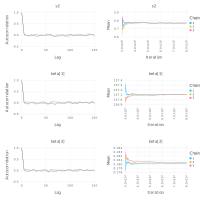

In [11]:
p = Mamba.plot(linear_sim, [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

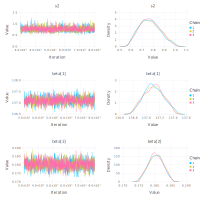

In [12]:
p = Mamba.plot(linear_sim, legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

In [123]:
gelmandiag(linear_sim[:, :beta, :], mpsrf = true, transform = true)

              PSRF 97.5%
     beta[1] 1.000 1.000
     beta[2] 1.001 1.002
Multivariate 1.001   NaN



muの95%信頼区間を表示

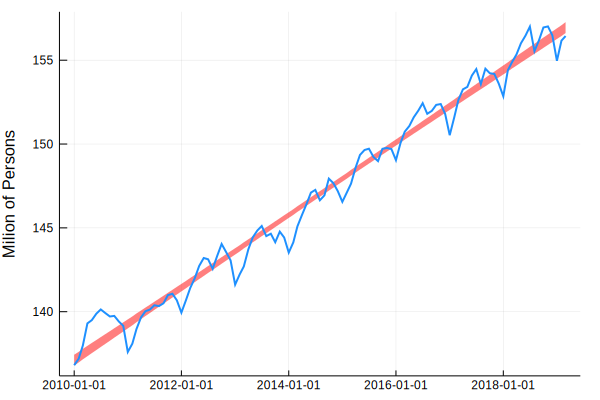

In [13]:
simulated_ys = mapslices(x -> linear_data[:xmat] * x, linear_sim[:, [:beta], :].value, dims = [2])
simulated_ys = permutedims(reshape(permutedims(simulated_ys, (2, 1, 3)), size(simulated_ys, 2), :))

sim_quantile = mapslices(v -> quantile(v, [0.025, 0.975]), simulated_ys, dims = [1])

Plots.plot(data_df[:date],
    sim_quantile[1, :],
    fillrange = sim_quantile[2, :], fillalpha = 0.5, fillcolor = :red,
    linewidth = 0,
    label = ""
)
Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :dodgerblue,
    ylabel = "Milion of Persons", 
    label = "")

beta, s2のmedianを使った場合のobsの95%信頼区間を表示

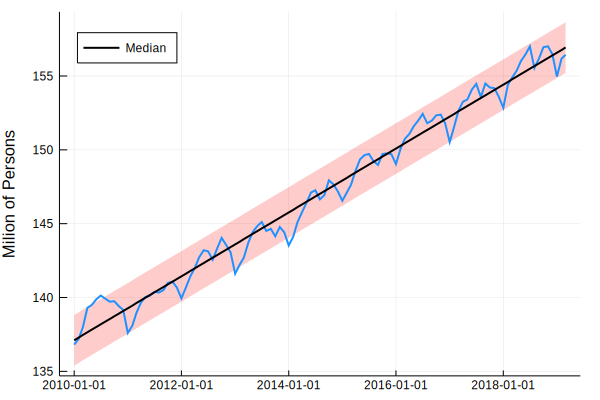

In [14]:
y_median = linear_data[:xmat] * vec(quantile(linear_sim[:, :beta, :]).value[:, 3, :])
ci_median = map(
    r -> quantile.(r, [0.025, 0.975]),
    Normal.(
        y_median,
        sqrt(median(linear_sim[:, [:s2], :].value))
    )
)
ci_median = hcat(ci_median...)

Plots.plot(data_df[:date],
    ci_median[1, :],
    fillrange = ci_median[2, :], fillalpha = 0.2, fillcolor = :red,
    linewidth = 0,
    label = ""
)
Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :dodgerblue,
    ylabel = "Milion of Persons", 
    label = "")
Plots.plot!(data_df[:date], 
    y_median,
    linewidth = 2, linecolor = :black,
    label = "Median", legend = :topleft,
)

## Local Linear Model
\begin{align*}
y_t &= T_t + I_t, \\
T_{t+1} &= T_t + \beta_t + a_{T_i}, \\
\beta_{t+1} &= \beta_t + \zeta_t, \\
I_t &\sim \mbox{Normal}(0, \sigma_I^2), \\
a_{T_i} &\sim \mbox{Normal}(0, \sigma_T^2), \\
T_0 &\sim \mbox{Normal}(0, 1000), \\
\zeta_t &\sim \mbox{Normal}(0, \sigma_\zeta^2), \\
\beta_0 &\sim \mbox{Normal}(0, 1000)\\
\sigma_I &\sim \mbox{HalfCauchy}(5)\\
\sigma_T &\sim \mbox{HalfCauchy}(5)\\
\sigma_\zeta &\sim \mbox{HalfCauchy}(5)\\
\end{align*}

In [203]:
include("gaussianrandomwalk.jl")

local_linear_model = Model(

    obs = Stochastic(1,
        (trend, s2_dist) -> MvNormal(trend, sqrt(s2_dist)),
        false
    ),
    
    trend = Stochastic(1,
        (beta, s2_trend) -> GaussianRandomWalk(beta, sqrt(s2_trend), Normal(0, sqrt(1000)))
    ),
    
    beta = Stochastic(1,
        (N, s2_beta) -> GaussianRandomWalk(zeros(N - 2), sqrt(s2_beta), Normal(0, sqrt(1000))),
    ),
    
    s2_dist = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    s2_trend = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    s2_beta = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
trend:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2_trend:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s2_beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2_dist:
A monitored node of type "ScalarStochastic"
NaN


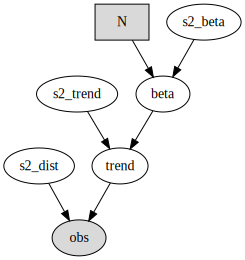

In [195]:
display("image/svg+xml", dot2svg(graph2dot(local_linear_model)))

In [196]:
local_linear_data = Dict(
    :obs => data_df[:value],
    :N => df_size,
)

Dict{Symbol,Any} with 2 entries:
  :N   => 111
  :obs => [136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.9…

In [197]:
local_linear_inits = [
    Dict(
        :obs => data_df[:value],
        :trend => data_df[:value],
        :beta => fill(mean(diff(data_df[:value])), df_size - 1),
        :s2_dist => 0.1,
        :s2_trend => 0.1,
        :s2_beta => 0.01,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>[0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473  …  0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473],:trend=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  156.465, 157.004, 155.539, 156.191, 156.952, 157.015, 156.481, 154.964, 156.167, 156.441],:s2_trend=>0.1,:s2_beta=>0.01,:obs=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  156.465, 157.004, 155.539, 156.191, 156.952, 157.015, 156.481, 154.964, 156.167, 156.441],:s2_dist=>0.1)
 Dict(:beta=>[0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473  …  0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473],:trend=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  

In [204]:
local_linear_scheme = [
    AMWG([:trend, :beta], 1.0),
    Slice([:s2_dist, :s2_trend, :s2_beta], [1.0, 1.0, 0.1], Univariate),
]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:trend, :beta]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Univariate}}"
Sampling Block Nodes:
Symbol[:s2_dist, :s2_trend, :s2_beta]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Array{Float64,1}}(false, [1.0, 1.0, 0.1]), Const(##287#289{Bool,Array{Float64,1}}(false, [1.0, 1.0, 0.1]), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                            

In [205]:
setsamplers!(local_linear_model, local_linear_scheme)
local_linear_sim = mcmc(
    local_linear_model, local_linear_data, local_linear_inits, 
    15000, burnin = 5000, thin = 10, chains = 3)

MCMC Simulation of 15000 Iterations x 3 Chains...

      From worker 3:	Chain 1:   0% [0:05:52 of 0:05:52 remaining]
      From worker 4:	Chain 2:   0% [0:06:16 of 0:06:16 remaining]
      From worker 2:	Chain 3:   0% [0:07:11 of 0:07:11 remaining]
      From worker 3:	Chain 1:  10% [0:02:04 of 0:02:18 remaining]
      From worker 4:	Chain 2:  10% [0:02:05 of 0:02:19 remaining]
      From worker 2:	Chain 3:  10% [0:02:08 of 0:02:22 remaining]
      From worker 4:	Chain 2:  20% [0:01:47 of 0:02:13 remaining]
      From worker 3:	Chain 1:  20% [0:01:48 of 0:02:15 remaining]
      From worker 2:	Chain 3:  20% [0:01:50 of 0:02:17 remaining]
      From worker 4:	Chain 2:  30% [0:01:32 of 0:02:11 remaining]
      From worker 3:	Chain 1:  30% [0:01:33 of 0:02:13 remaining]
      From worker 2:	Chain 3:  30% [0:01:35 of 0:02:15 remaining]
      From worker 4:	Chain 2:  40% [0:01:19 of 0:02:12 remaining]
      From worker 3:	Chain 1:  40% [0:01:20 of 0:02:14 remaining]
      From worker 2:	Chai

Object of type "ModelChains"

Iterations = 5010:15000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1000

[0.00890471 0.533078 … 156.173 156.524; 0.0175445 0.38036 … 156.268 156.52; … ; 0.0548811 0.408933 … 156.026 156.641; 0.079135 0.48339 … 155.918 156.666]

[0.0220987 0.534134 … 156.425 156.603; 0.0173529 0.43283 … 156.014 156.301; … ; 0.00526886 0.516011 … 156.02 156.462; 0.00514942 0.450569 … 156.218 156.517]

[0.021882 0.465519 … 156.072 156.608; 0.0191129 0.355355 … 156.196 156.476; … ; 0.0186387 0.313594 … 156.106 156.4; 0.0237173 0.305951 … 155.838 156.346]

In [206]:
describe(local_linear_sim)

Iterations = 5010:15000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1000

Empirical Posterior Estimates:
                Mean          SD         Naive SE        MCSE         ESS    
   s2_dist   0.018069068 0.0184352286 0.00033657968 0.00180143295  104.727527
  s2_trend   0.412131289 0.0640811363 0.00116995613 0.00234186069  748.752516
   s2_beta   0.003157156 0.0039816976 0.00007269552 0.00045340444   77.119642
   beta[1]   0.274984374 0.2000425259 0.00365226013 0.02594160351   59.463576
   beta[2]   0.272897509 0.1925584858 0.00351562088 0.02592431152   55.171001
   beta[3]   0.267576494 0.1877313821 0.00342749042 0.02588887198   52.583259
   beta[4]   0.255113247 0.1776550498 0.00324352261 0.02523791285   49.550523
   beta[5]   0.243267894 0.1709789455 0.00312163418 0.02433353654   49.371327
   beta[6]   0.229853295 0.1646030722 0.00300522719 0.02378797788   47.880736
   beta[7]   0.218965920 0.1588801788 0.00290074193 0.02289132169   48.172336
   beta[8]   0.20851360

 trend[16] 139.647634674 0.1264511144 0.00230867093 0.00387152980 1000.000000
 trend[17] 140.017346297 0.1222746429 0.00223241934 0.00259894060 1000.000000
 trend[18] 140.139318315 0.1268622114 0.00231617650 0.00310011900 1000.000000
 trend[19] 140.373942396 0.1254835202 0.00229100515 0.00322045523 1000.000000
 trend[20] 140.348347433 0.1220814525 0.00222889218 0.00298824037 1000.000000
 trend[21] 140.512487512 0.1260442652 0.00230124291 0.00338307184 1000.000000
 trend[22] 140.969328375 0.1283324347 0.00234301898 0.00450540860  811.343014
 trend[23] 141.049997808 0.1260788069 0.00230187355 0.00373327045 1000.000000
 trend[24] 140.669729434 0.1266510536 0.00231232130 0.00313946511 1000.000000
 trend[25] 139.996781259 0.1325623811 0.00242024688 0.00583002305  517.011316
 trend[26] 140.685792537 0.1174624763 0.00214456160 0.00280896926 1000.000000
 trend[27] 141.407874523 0.1262789346 0.00230552737 0.00217624686 1000.000000
 trend[28] 142.000820505 0.1242207289 0.00226794984 0.0019595724

  beta[29]  -0.03116838926   0.12897651775   0.2046447222   0.3033585664   0.490103184
  beta[30]  -0.06071771357   0.12258639979   0.1962533528   0.2917528255   0.470228712
  beta[31]  -0.06519195410   0.11555832926   0.1878986344   0.2844104525   0.464372958
  beta[32]  -0.06972481617   0.11380672065   0.1886730245   0.2841164901   0.443756116
  beta[33]  -0.08570837940   0.11044045452   0.1866216937   0.2845638855   0.439844199
  beta[34]  -0.10198450753   0.10337211872   0.1775934945   0.2693120363   0.434269493
  beta[35]  -0.11723064369   0.10390367767   0.1763113964   0.2614887870   0.429501297
  beta[36]  -0.12667606630   0.10242239538   0.1744421480   0.2603041914   0.415710255
  beta[37]  -0.09241384468   0.11384828641   0.1866983210   0.2686753148   0.426112460
  beta[38]  -0.07262629214   0.12286358822   0.1960235306   0.2785914188   0.436019124
  beta[39]  -0.04804831370   0.12781613888   0.2033261377   0.2849077075   0.434472183
  beta[40]  -0.03926486327   0.12911945027 

 trend[73] 148.86410836334 149.01612887682 149.0735344148 149.1713883787 149.441381288
 trend[74] 149.79235926676 149.98239406653 150.0527697141 150.1156376330 150.311657157
 trend[75] 150.44292984915 150.66437138496 150.7324361911 150.7932283652 150.971798731
 trend[76] 150.81087480408 151.01793510932 151.0821054882 151.1491477890 151.346492529
 trend[77] 151.30126382956 151.52249136836 151.5874740968 151.6507610605 151.830648767
 trend[78] 151.71261608748 151.92416940567 151.9889406153 152.0482943642 152.234390737
 trend[79] 152.06809602993 152.34034865544 152.4108957658 152.4678948992 152.634268589
 trend[80] 151.57853663028 151.76393141301 151.8220590661 151.8964088969 152.118965488
 trend[81] 151.72357552123 151.91789669996 151.9805091128 152.0479067993 152.248609747
 trend[82] 152.04895398966 152.25519278430 152.3228411880 152.3827615384 152.574961524
 trend[83] 152.05442726354 152.29665142633 152.3677925813 152.4261430399 152.580558738
 trend[84] 151.48232739559 151.70876507000 

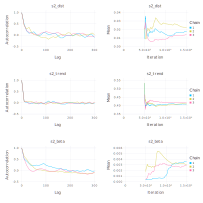

In [207]:
p = Mamba.plot(local_linear_sim[:, [:s2_dist, :s2_trend, :s2_beta], :], [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

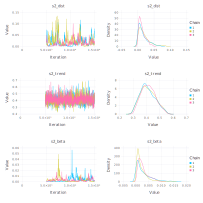

In [208]:
p = Mamba.plot(local_linear_sim[:, [:s2_dist, :s2_trend, :s2_beta], :], legend = true)
Mamba.draw(p, nrow = 3, ncol = 2)

In [209]:
gelmandiag(local_linear_sim[:, [:s2_dist, :s2_trend, :s2_beta], :], mpsrf = true, transform = true)

              PSRF 97.5%
     s2_dist 1.051 1.146
    s2_trend 1.004 1.013
     s2_beta 1.030 1.050
Multivariate 1.070   NaN



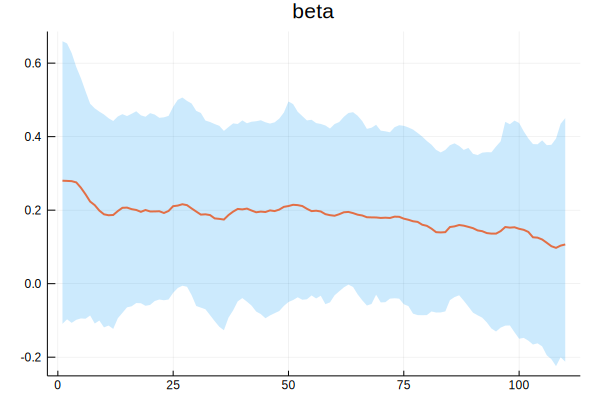

In [210]:
Plots.plot(
    quantile(local_linear_sim[:, [:beta], :]).value[:, 1, :],
    fillrange = quantile(local_linear_sim[:, [:beta], :]).value[:, 5, :], fillalpha = 0.2,
    linewidth = 0,
    label = ""
)
Plots.plot!(quantile(local_linear_sim[:, [:beta], :]).value[:, 3, :], 
    linewidth = 2,
    label = "", title = "beta")

trendの95%信頼区間を表示

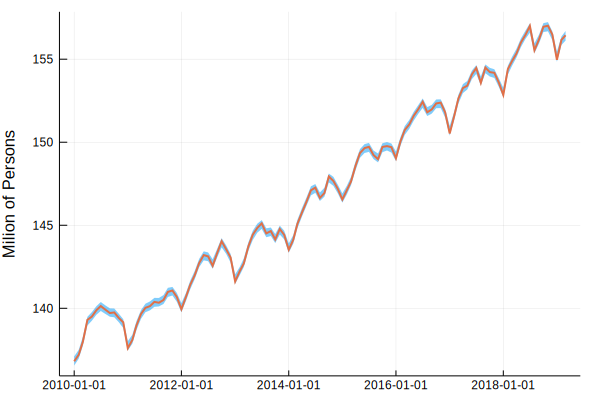

In [211]:
Plots.plot(data_df[:date], 
    quantile(local_linear_sim[:, [:trend], :]).value[:, 1, :],
    fillrange = quantile(local_linear_sim[:, [:trend], :]).value[:, 5, :],
    fillalpha = 0.5, 
    linewidth = 0,
    label = "")

Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2,
    ylabel = "Milion of Persons", 
    label = "")

trend, s2_trendを使った場合のobsの95%信頼区間を表示

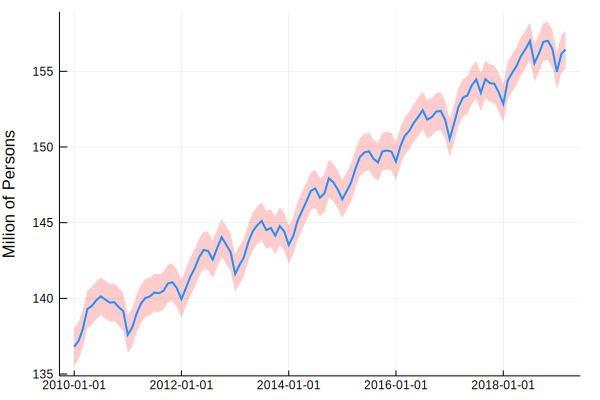

In [212]:
ci_median = map(
    r -> quantile.(r, [0.025, 0.975]),
    Normal.(
        vec(quantile(local_linear_sim[:, [:trend], :]).value[:, 3, :]),
        sqrt(median(local_linear_sim[:, [:s2_trend], :].value))
    )
)
ci_median = hcat(ci_median...)

Plots.plot(data_df[:date], 
    ci_median[1, :],
    fillrange = ci_median[2, :],
    fillalpha = 0.2, fillcolor = :red,
    linewidth = 0,
    label = "")

Plots.plot!(data_df[:date], data_df[:value],
    linewidth = 2, linecolor = :dodgerblue,
    ylabel = "Milion of Persons", 
    label = "")

## Dummy Seasonal
さらに季節項$S_t$を導入する
\begin{align*}
y_t &= T_t + S_t + I_t, \\
T_{t+1} &= T_t + \beta_t + a_{T_i}, \\
\beta_{t+1} &= \beta_t + \zeta_t, \\
I_t &\sim \mbox{Normal}(0, \sigma_I^2), \\
a_{T_i} &\sim \mbox{Normal}(0, \sigma_T^2), \\
T_0 &\sim \mbox{Flat}(0, \infty), \\
\zeta_t &\sim \mbox{Normal}(0, \sigma_\zeta^2), \\
\beta_0 &\sim \mbox{Flat}(0, \infty)\\
\end{align*}

ここで、季節項は
\begin{align*}
S_t &= - \sum_j^{11}S_{t-j} + \omega_t, \\
\omega_t &\sim \mbox{Normal}(0, \sigma_\omega^2), \\
\end{align*}

In [213]:
include("gaussianrandomwalk.jl")

local_linear_seasonal_model = Model(

    obs = Stochastic(1,
        (trend, seasonal, s2_dist) -> MvNormal(trend + seasonal, sqrt(s2_dist)),
        false
    ),
    
    trend = Stochastic(1,
        (beta, s2_trend) -> GaussianRandomWalk(beta, sqrt(s2_trend), Normal(0, sqrt(1000)))
    ),
    
    beta = Stochastic(1,
        (N, s2_beta) -> GaussianRandomWalk(zeros(N - 2), sqrt(s2_beta), Normal(0, sqrt(1000))),
    ),
    
    seasonal = Stochastic(1,
        (N, s2_omega) -> 
        SeasonalRandomWalk(zeros(N - 11), sqrt(s2_omega), MvNormal(11, sqrt(1000)))
    ),
    
    s2_dist = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    s2_trend = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    s2_beta = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
    s2_omega = Stochastic(() -> Truncated(Cauchy(0, 5), 0, Inf)),
)

Object of type "Model"
-------------------------------------------------------------------------------
beta:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
trend:
A monitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2_trend:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s2_beta:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
obs:
An unmonitored node of type "0-element ArrayStochastic{1}"
Float64[]
-------------------------------------------------------------------------------
s2_omega:
A monitored node of type "ScalarStochastic"
NaN
-------------------------------------------------------------------------------
s2_dist:
A monitored node

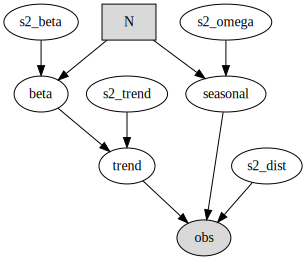

In [57]:
display("image/svg+xml", dot2svg(graph2dot(local_linear_seasonal_model)))

In [58]:
local_linear_seasonal_data = local_linear_data

Dict{Symbol,Any} with 2 entries:
  :N   => 111
  :obs => [136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.9…

In [221]:
local_linear_seasonal_inits = [
    Dict(
        :obs => data_df[:value],
        :trend => data_df[:value],
        :beta => fill(mean(diff(data_df[:value])), df_size - 1),
        :seasonal => zeros(df_size),
        :s2_dist => 0.1,
        :s2_trend => 0.1,
        :s2_beta => 0.01,
        :s2_omega => 0.01,
    ) for _ in 1:3
]

3-element Array{Dict{Symbol,Any},1}:
 Dict(:beta=>[0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473  …  0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473],:trend=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  156.465, 157.004, 155.539, 156.191, 156.952, 157.015, 156.481, 154.964, 156.167, 156.441],:s2_trend=>0.1,:s2_beta=>0.01,:obs=>[136.809, 137.203, 137.983, 139.302, 139.497, 139.882, 140.134, 139.919, 139.715, 139.749  …  156.465, 157.004, 155.539, 156.191, 156.952, 157.015, 156.481, 154.964, 156.167, 156.441],:s2_omega=>0.01,:s2_dist=>0.1,:seasonal=>[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 Dict(:beta=>[0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473  …  0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0.178473, 0

In [215]:
local_linear_seasonal_scheme = [
    AMWG([:trend, :beta, :seasonal], 1.0),
    Slice([:s2_dist, :s2_trend, :s2_beta, :s2_omega], 0.1, Univariate),
]

2-element Array{Sampler,1}:
 An object of type "Sampler{Mamba.AMWGTune}"
Sampling Block Nodes:
Symbol[:trend, :beta, :seasonal]

CodeInfo(
1 ─ %1 = π (##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), Const(##198#200{Symbol,Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}},Float64}(:all, Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}(), 1.0), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any

 An object of type "Sampler{Mamba.SliceTune{Univariate}}"
Sampling Block Nodes:
Symbol[:s2_dist, :s2_trend, :s2_beta, :s2_omega]

CodeInfo(
1 ─ %1 = π (##287#289{Bool,Float64}(false, 0.1), Const(##287#289{Bool,Float64}(false, 0.1), false))
│   %2 = (%1)(model, block)::Any
└──      return %2
) => Any
                                                                                                                                                

In [222]:
setsamplers!(local_linear_seasonal_model, local_linear_seasonal_scheme)
local_linear_seasonal_sim = mcmc(
    local_linear_seasonal_model, local_linear_seasonal_data, local_linear_seasonal_inits, 
    15000, burnin = 5000, thin = 10, chains = 3)

MCMC Simulation of 15000 Iterations x 3 Chains...

      From worker 2:	Chain 2:   0% [0:14:22 of 0:14:22 remaining]
      From worker 4:	Chain 3:   0% [0:14:47 of 0:14:48 remaining]
      From worker 3:	Chain 1:   0% [0:15:18 of 0:15:18 remaining]
      From worker 3:	Chain 1:  10% [0:05:37 of 0:06:14 remaining]
      From worker 2:	Chain 2:  10% [0:05:44 of 0:06:23 remaining]
      From worker 4:	Chain 3:  10% [0:05:45 of 0:06:23 remaining]
      From worker 3:	Chain 1:  20% [0:05:33 of 0:06:56 remaining]
      From worker 2:	Chain 2:  20% [0:05:37 of 0:07:02 remaining]
      From worker 4:	Chain 3:  20% [0:05:38 of 0:07:02 remaining]
      From worker 3:	Chain 1:  30% [0:04:46 of 0:06:48 remaining]
      From worker 2:	Chain 2:  30% [0:04:49 of 0:06:53 remaining]
      From worker 4:	Chain 3:  30% [0:04:51 of 0:06:55 remaining]
      From worker 3:	Chain 1:  40% [0:03:58 of 0:06:37 remaining]
      From worker 2:	Chain 2:  40% [0:04:01 of 0:06:41 remaining]
      From worker 4:	Chai

Object of type "ModelChains"

Iterations = 5010:15000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1000

[3.67792e-5 0.0346475 … 156.095 156.318; 3.717e-5 0.0378491 … 156.43 156.249; … ; 1.35327e-5 0.0135697 … 156.1 156.282; 1.06148e-5 0.0182872 … 156.162 156.361]

[4.03619e-5 0.0395092 … 156.46 156.734; 2.79351e-5 0.0318823 … 156.2 156.454; … ; 1.96118e-5 0.00109796 … 156.169 156.418; 2.36999e-5 0.000719867 … 156.172 156.433]

[0.000111415 0.0164161 … 156.147 156.362; 7.57094e-5 0.0187291 … 156.327 156.46; … ; 9.42676e-5 0.0193834 … 156.036 156.55; 9.19237e-5 0.0184572 … 156.129 156.278]

In [223]:
describe(local_linear_seasonal_sim)

Iterations = 5010:15000
Thinning interval = 10
Chains = 1,2,3
Samples per chain = 1000

Empirical Posterior Estimates:
                    Mean             SD           Naive SE         MCSE          ESS    
     s2_omega   0.000052008174 0.000038998182 0.0000007120061 0.000006739387   33.484816
      s2_dist   0.022694201244 0.020905899139 0.0003816877514 0.001856649504  126.787912
     s2_trend   0.399368588801 0.064051451753 0.0011694141655 0.002855910189  503.001017
      s2_beta   0.000966823621 0.001926156040 0.0000351666371 0.000276554667   48.508847
  seasonal[1]  -0.002716865975 0.017235384149 0.0003146736229 0.002524927277   46.595523
  seasonal[2]   0.001836645747 0.018743153399 0.0003422015972 0.003037377263   38.079202
  seasonal[3]  -0.007884203235 0.017277934345 0.0003154504796 0.002669358812   41.895727
  seasonal[4]   0.012722699105 0.015013172133 0.0002741017679 0.002306808046   42.356690
  seasonal[5]  -0.000201342644 0.013700123588 0.0002501288910 0.002163436708   4

seasonal[109]  -0.003311885605 0.015514461880 0.0002832540246 0.002201434116   49.666328
seasonal[110]   0.004013494253 0.023160237072 0.0004228461427 0.003851934818   36.151652
seasonal[111]   0.005832662185 0.018184380593 0.0003319998482 0.002732134436   44.298895
      beta[1]   0.216228122931 0.098920059675 0.0018060249358 0.010906318423   82.264487
      beta[2]   0.214806538203 0.093964296504 0.0017155454932 0.010751392367   76.382929
      beta[3]   0.211305071625 0.092139729619 0.0016822336118 0.010855408972   72.044609
      beta[4]   0.205976423353 0.091587504078 0.0016721513990 0.011463098325   63.836404
      beta[5]   0.200987120535 0.092477466730 0.0016883998196 0.012033677894   59.057503
      beta[6]   0.195539081176 0.091468478412 0.0016699782976 0.012400929523   54.404451
      beta[7]   0.190333626738 0.092668316739 0.0016918842481 0.012839044689   52.095130
      beta[8]   0.186112468989 0.094016815691 0.0017165043580 0.013259798188   50.273283
      beta[9]   0.183

     trend[4] 139.234093083405 0.145962312498 0.0026648950367 0.006474007392  508.317532
     trend[5] 139.502774299416 0.139207557334 0.0025415706442 0.004295983731 1000.000000
     trend[6] 139.880957586117 0.144904751554 0.0026455867039 0.004195013047 1000.000000
     trend[7] 140.096401182671 0.139532755088 0.0025475079158 0.003864435467 1000.000000
     trend[8] 139.925301926713 0.138807705236 0.0025342703771 0.005438568236  651.415346
     trend[9] 139.720144435204 0.140519829684 0.0025655293498 0.004892693525  824.858025
    trend[10] 139.753471034400 0.143256953696 0.0026155021686 0.005141084090  776.465223
    trend[11] 139.390750433277 0.142609192432 0.0026036757201 0.005729518699  619.524889
    trend[12] 139.105680054976 0.145781322808 0.0026615906322 0.006000530844  590.234279
    trend[13] 137.703266441001 0.159967019124 0.0029205848277 0.009504667209  283.261189
    trend[14] 138.117679903409 0.144763873238 0.0026430146295 0.005332109927  737.092853
    trend[15] 138.955

   trend[104] 155.652712921754 0.156961810901 0.0028657174832 0.009547044278  270.302541
   trend[105] 156.187533932619 0.142034241062 0.0025931785923 0.003444307116 1000.000000
   trend[106] 156.922288435124 0.140597886424 0.0025669544644 0.005268210217  712.248251
   trend[107] 156.969104172356 0.143051662972 0.0026117540899 0.006007453475  567.028633
   trend[108] 156.445280524886 0.146724764885 0.0026788154491 0.005017103636  855.265001
   trend[109] 155.095880494267 0.172549781850 0.0031503135937 0.010596991889  265.132902
   trend[110] 156.125405241571 0.144219432024 0.0026330745383 0.005663496160  648.452757
   trend[111] 156.429825276806 0.141275017566 0.0025793171311 0.003990982593 1000.000000

Quantiles:
                    2.5%             25.0%           50.0%           75.0%           97.5%    
     s2_omega   0.000009020690   0.000023487973   0.00003654868   0.00007453054   0.0001498385
      s2_dist   0.001422733221   0.007718692053   0.01628477901   0.03115497770   0.07

 seasonal[97]  -0.026171220455  -0.012315764904  -0.00504121960   0.00477030558   0.0186685111
 seasonal[98]  -0.021549325331  -0.008226893982  -0.00114202735   0.00694381858   0.0605814089
 seasonal[99]  -0.018035526977  -0.009243912547   0.00316551893   0.02077790027   0.0379367427
seasonal[100]  -0.063212584653  -0.026189726035  -0.01533729790   0.00189641084   0.0170146716
seasonal[101]  -0.019066809087  -0.005328660431   0.00572781323   0.01518137058   0.0353255099
seasonal[102]  -0.025494030280  -0.002977836653   0.00573605261   0.01247423829   0.0198632558
seasonal[103]  -0.014621107114  -0.003263824276   0.00285325213   0.01238414782   0.0369105746
seasonal[104]  -0.070901944586  -0.037774091408  -0.01269118650  -0.00296890582   0.0111084662
seasonal[105]  -0.000280008304   0.005815701506   0.00943495714   0.02566787841   0.0542531116
seasonal[106]  -0.046085869693  -0.026179314530  -0.00953884489   0.00051826184   0.0145201805
seasonal[107]  -0.016418631635  -0.003276832958   

     beta[93]  -0.017907242364   0.157408860433   0.18964713421   0.23845774265   0.3877852790
     beta[94]  -0.023060491599   0.154837715817   0.18758526186   0.23616439502   0.3795981031
     beta[95]  -0.027123216116   0.152917246321   0.18669486871   0.23703168555   0.3925045930
     beta[96]  -0.020138310997   0.151220076586   0.18610694261   0.23591704946   0.4057276207
     beta[97]  -0.012595236172   0.151554295576   0.18742927823   0.23928499786   0.4299959885
     beta[98]  -0.009186435702   0.153960321964   0.18615884756   0.23843407122   0.4400766515
     beta[99]  -0.011245468878   0.151731895590   0.18526981664   0.23992476979   0.4274960308
    beta[100]  -0.001190451842   0.148212222679   0.18518954728   0.23903833923   0.4252839586
    beta[101]  -0.004877763106   0.144476785385   0.18341299486   0.23437421013   0.4189372215
    beta[102]  -0.024286252429   0.143652034278   0.18220669622   0.23249119153   0.4142189783
    beta[103]  -0.026332603173   0.140211488745   

    trend[91] 154.079316026663 154.343398101254 154.42956503710 154.50207310626 154.6423481930
    trend[92] 153.402654981971 153.571859107053 153.64454787412 153.73839075755 154.0304504212
    trend[93] 154.081362440310 154.357738302304 154.44446575580 154.51137648431 154.6657096026
    trend[94] 153.944011559040 154.164042401915 154.23770639600 154.30960022345 154.5163273000
    trend[95] 153.815063532854 154.069264108482 154.15301070977 154.22962850193 154.4355931204
    trend[96] 153.311597818334 153.525643228065 153.59882329835 153.67186296592 153.9014966300
    trend[97] 152.713221766527 152.851182169284 152.93083280222 153.04443017988 153.3782110937
    trend[98] 154.020276895512 154.270346850784 154.36338666004 154.43400499375 154.6043576362
    trend[99] 154.580201135466 154.793568463684 154.87109055363 154.94726464314 155.1577926984
   trend[100] 155.090379700542 155.289965917325 155.36331686117 155.44188285785 155.6731728382
   trend[101] 155.689910803686 155.923181577905 15

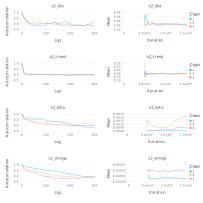

In [224]:
p = Mamba.plot(local_linear_seasonal_sim[:, [:s2_dist, :s2_trend, :s2_beta, :s2_omega], :], 
    [:autocor, :mean], legend = true)
Mamba.draw(p, nrow = 4, ncol = 2)

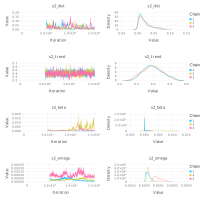

In [225]:
p = Mamba.plot(local_linear_seasonal_sim[:, [:s2_dist, :s2_trend, :s2_beta, :s2_omega], :], 
    legend = true)
Mamba.draw(p, nrow = 4, ncol = 2)

In [230]:
gelmandiag(local_linear_seasonal_sim[:, [:s2_dist, :s2_trend, :s2_beta, :s2_omega], :], mpsrf = true, transform = true)

DomainError: DomainError with [7.79851 5.07443 680.412 -96.4374; 18.0259 3.19027 583.857 -20.7683; 50.1986 20.211 2937.65 -325.972; 512.903 -68.3996 -1820.78 3177.16]:
`A` cannot have complex eigenvalues.

### 季節項のMedianと95%信頼区間を表示

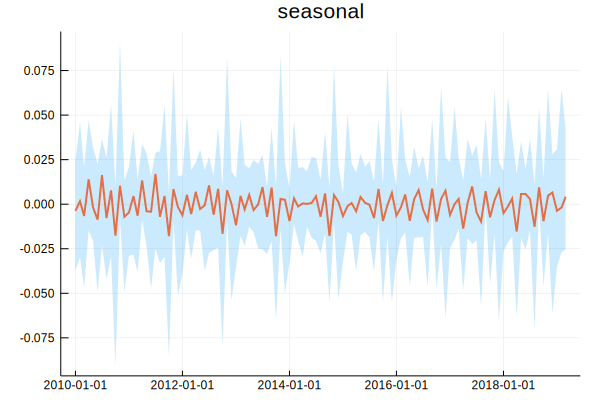

In [229]:
Plots.plot(data_df[:date],
    quantile(local_linear_seasonal_sim[:, [:seasonal], :]).value[:, 1, :],
    fillrange = quantile(local_linear_seasonal_sim[:, [:seasonal], :]).value[:, 5, :], fillalpha = 0.2,
    linewidth = 0,
    label = ""
)
Plots.plot!(data_df[:date],
    quantile(local_linear_seasonal_sim[:, [:seasonal], :]).value[:, 3, :], 
    linewidth = 2,
    label = "", title = "seasonal")